In [37]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\silve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\silve\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\silve\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [38]:
os.chdir("E:/NLP-with-Disaster-Tweets")
os.getcwd()

'E:\\NLP-with-Disaster-Tweets'

In [39]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Disaster Tweet Classification through TensorFlow Recurrent Nueral Networks

## Problem and Data Description

In this project I will pull data we will construct a couple RNNs to classify binary text data as either "disaster" or "not disaster". The data come from a (Kaggle "getting started" competition)[https://www.kaggle.com/competitions/nlp-getting-started/overview] designed to be an excellent introduction to Natural Language Processing. The goal of NLP is to input text data and output something. NLP could output a "mood" for sentiment analysis, a predicted stock price from ticker mentions, more text in the frame of language conversion, and countless other outputs in a variety of applications. I will utilize TensorFlow's Keras API to build a recurrent nueral network to perform binary classification. A recurrent nueral network is suited for data with a fixed series, for example: time series data like stock price, code translation from one language to machine language, next-frame generation from videos and/or gifs, and as I perform in the following project text classification in buckets - disaster vs. not disaster. 

The data in this project are tweets. There are three meaningful features: the full text of the tweet, the location from which the tweet was made, and a keyword the authors tagged as potentially indicating an accident. Note that not all keyword inclusions are the result of disasters.

Here's a barebones description of the data we will be modelling in this project. We will do a more thourough investigation in my EDA section:

In [40]:
train_df = pd.read_csv("./nlp-getting-started/train.csv")
test_df = pd.read_csv("./nlp-getting-started/test.csv")

print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [41]:
print(train_df.describe())

                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


In [42]:
#Random subset of rows
from random import sample
rows = sample([i for i in range(7613)], 5)
train_df.iloc[rows, :]

,id,keyword,location,text,target
2781,3998,disaster,"Los Angeles, London, Kent",I forgot to bring chocolate with me. Major dis...,0
370,530,army,NaN,Beyonce Is my pick for http://t.co/nnMQlz91o9 ...,0
3205,4599,emergency%20services,London,@TfLBusAlerts @TfLBusAlerts The Drive in Ilfor...,1
3554,5079,famine,Texas,The famine is coming to an end #Bluebell http:...,1
6557,9382,survived,U.K.,Well said Sir. My cousin was a POW. Brutally t...,1


## Cleaning and Exploratory Data Analysis

There are 7613 rows in the dataset total, of which id, text, and target are fully populated. Location is recorded for 5080 records, and there are keywords for all but 61 observations. We need to do some initial cleaning because the data types for keyword, location, and text should be strings, but they are "object". 

Here are the two questions I asked myself immediately: (1) Is keyword a useful predictor of target? (2) What about location? If variance in the features do not correlate with large variance in the binary response, we can say that the location / keyword can be ignored as a feature. Otherwise, we should include the feature. I'll make a histogram of counts ver proportion of tweets with each label for both keywords and targets, grouped by feature, for groups with at least 30 observations. We want to ensure we only include groups with at least 30 observations to let the central limit theorem do it's work. We should get a distribution that is approaching Gaussian if the feature is "nice". This happens to be easier to do in R using tidyverse, so I'll do it there and import the graphs I made. I will also provide a copy of the .rmd in my GitHub repo for this project for the sake of reproducability. Let's start with location.

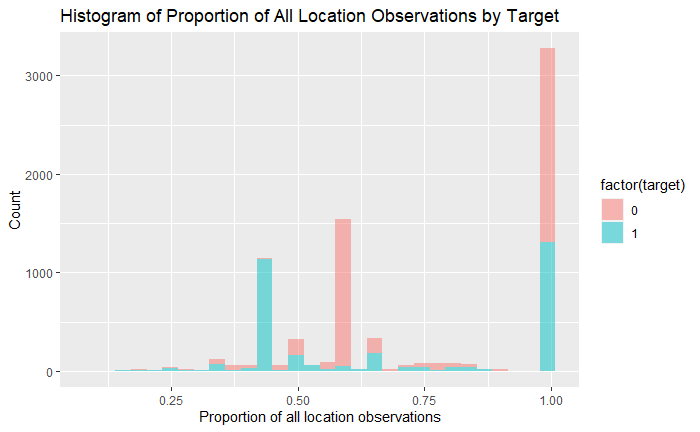

What can we learn from this? The locations are super high-variance entities, and don't resemble a nice probability distribution. Although nueral networks are universal function approximators and so could reproduce the location distribution for the training data, the locations are so high variance that we are unlikely to gain much advantage from feeding the RNN location information. Some locations are very rare, so we could drastically overfit based on location. Even if we don't (by heavily controlling for validation accuracy), the computation cost vs. marginal benefit to binary crossentropy seems not worthwhile. 

As further evidence against usage of location as a feature, let's look at a histogram of the marginal pdf for location.

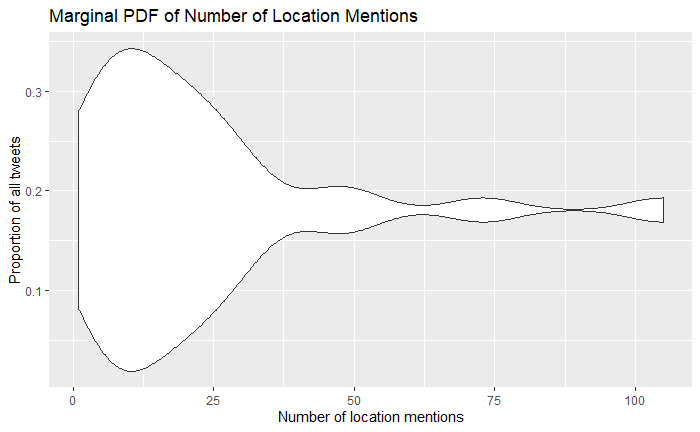

Now let's look at keyword.


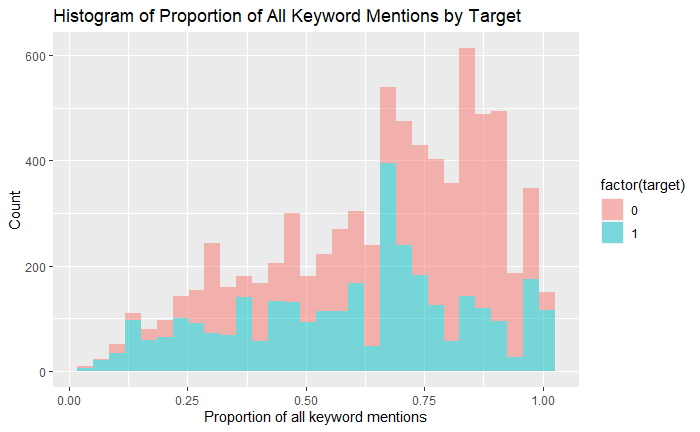

Keyword is a fabulous feature in contrast to location. The pdf per target value is reasonably continuous and ranges over a wide swath of the domain $[0, 1]$. One thing though - inclusion of keyword doesn't pass a sanity check. The reason the keyword exists is because it is a standout **word in the tweet** that might indicate the presence of a disaster. It doesn't make sense to manually weight any given keyword more than any other, because the whole point of using a nueral network on NLP is to let it find the optimal weights for each word / character. So, in summary: we have reason to completely exclude both location and keyword from our nueral network. This has the added benefit of allowing us to use the entire training dataset without pruning missing values, because every tweet has text. ID is also not a useful feature - it seems like vestigial as a primary key from the original dataset before splitting into test and train and hosting on Kaggle.

Here's the pdf for keyword, if you were interested.

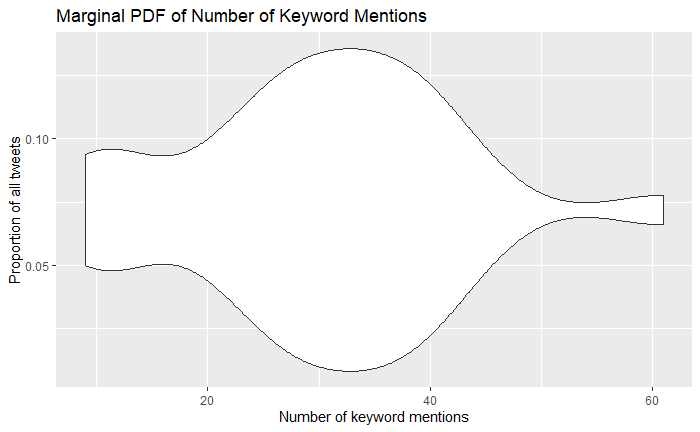

Here's the updated training data:

In [43]:
# Remove keyword and location features from test and train
tweets_train_df = train_df[["id", "text", "target"]].sort_values(by = "id")
tweets_test_df = test_df[["id", "text"]].sort_values(by = "id")

# Updated training dataframe
tweets_train_df.iloc[rows]

,id,text,target
2781,3998,I forgot to bring chocolate with me. Major dis...,0
370,530,Beyonce Is my pick for http://t.co/nnMQlz91o9 ...,0
3205,4599,@TfLBusAlerts @TfLBusAlerts The Drive in Ilfor...,1
3554,5079,The famine is coming to an end #Bluebell http:...,1
6557,9382,Well said Sir. My cousin was a POW. Brutally t...,1


### Transformation with TF-IDF:

TF-IDF stands for term frequency - inverse data frequency. TF-IDF constructs a skewed matrix, which then can be normalized into a form that is convenient to factor. Fortunately sklearn takes care of this normalization for us. In TF-IDF each word is given a weight which balances it's frequency with its rarity, the underlying idea being that globally rare words are useful as categorical identifiers, and the more frequent such "buzzwords" are used the more clear indication of a category it is. Here's the math:

The frequency of a term in a document (i.e. a word or phrase, but in our implementation it will just be a word due to processing time concerns) is calculated as:

$$TF(i, j) = \frac{\text{Frequency of term i in document j}}{\text{Total word count of document j}}$$

The inverse document frequency of a term over all documents is calculated as:

$$IDF(i) = \log_2{\frac{\text{Total number of documents}}{\text{Number of documents with term i}}}$$

By multiplying these quantities, we obtain weights for word "usefulness" in identifying categories. We can run this over all articles in a desired dataframe (either test or train) to construct a matrix of dimension (number of documents, number of unique terms). 

One issue is that stopwords like "the", "I", "we", "he", etc. are the most prevalent in text, and do not indicate whether a disaster has taken place. As such the weights will be very slow to update in our GAN. We therefore need to cleanse the stopwords. There are some fortunately very good libraries for this!


In [44]:

#Function courtesy of Shradda Anala
def fix_stopwords(ds: pd.Series) -> pd.Series: 
    """
    Apply NLP Preprocessing Techniques to the reviews.
    """
    for m in range(len(ds)):
        if m % 1000 == 0: #Rudimentary progress bar. Feel free to remove, but this bit takes a while so it's nice.
            print(m)
        main_words = re.sub('[^a-zA-Z]', ' ', ds[m])                                      # Retain only alphabets
        main_words = (main_words.lower()).split()
        main_words = [w for w in main_words if not w in set(stopwords.words('english'))]  # Remove stopwords
        
        lem = WordNetLemmatizer()
        main_words = [lem.lemmatize(w) for w in main_words if len(w) > 1]                 # Group different forms of the same word
        
        main_words = ' '.join(main_words)
        ds[m] = main_words

    return ds

#Clean up stopwords from test and train
tweets_train_df["text"] = fix_stopwords(tweets_train_df["text"])
tweets_test_df["text"] = fix_stopwords(tweets_test_df["text"])

0


C:\Users\silve\AppData\Local\Temp\ipykernel_27504\1892226191.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds[m] = main_words


1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000


In [45]:
# Feature extraction on training data
train_corpus = tweets_train_df["text"].tolist()
vector = TfidfVectorizer(max_features=1000)
interemresponse = vector.fit(train_corpus)

train_and_val = interemresponse.transform(tweets_train_df["text"]).todense()

X_train, X_val, y_train, y_val = train_test_split(train_and_val, tweets_train_df["target"], test_size=0.08, random_state=42)

X_test = interemresponse.transform(tweets_test_df["text"]).todense()

#Sanity check to make sure all the TF-IDF matrix dimensions are correct.
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape)

(7003, 1000) (610, 1000) (3263, 1000)
(7003,) (610,)


## Model Architecture, Results, and Analysis
The tensorflow team supplies [a tutorial for using RNN for text classification](https://www.tensorflow.org/text/tutorials/text_classification_rnn) which I will be following and adapting for this project. The tutorial uses an auto-encoder, and so we will actually change tack and not use TF-IDF with the RNN and just do an ANN with TF-IDF. We will then compare against the RNN as an architecture optimization.

In [46]:
def buildANN_Model(eta):
    """
        Builds a bidirectional RNN to predict whether a tweet indicates a disaster occurance.
        Input:
            float eta, the initial learning rate
            string compiler, either "Adam" or "RMSprop"
        Output:
            
    """
    
    shape = (1000, )
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate = eta,
      decay_steps = 1000,
      decay_rate=0.9
      ) 
    
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape = shape))
    model.add(tf.keras.layers.Dense(128, activation = "relu"))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(128, activation = "relu"))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(1, activation = "sigmoid"))   
    
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )    
    return(model)

In [47]:
# Visualize the ANN model with TF-IDF
testModel = buildANN_Model(0.0001)
testModel.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               128128    
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 128)               16512     
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 1)                 129       
                                                                 
Total params: 144,769
Trainable params: 144,769
Non-trainable params: 0
_________________________________________________________________


In [48]:
def gridSearch(eta_to_try, X_train, y_train, X_valid, y_valid):
    """
        Hyperparameter optimizer for ANN using TF-IDF
        Input: list of floats eta_to_try
        Output: (keras.callbacks.History best_history, float best_eta) current_best[1:]
    """
    callbacks_list =  [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5, mode = "min")]

    current_best = (0, None, None)
    for eta in eta_to_try:
        print("Now fitting model with eta =", eta)
        this_model = buildANN_Model(eta)
        this_history = this_model.fit(X_train,
                            y = y_train,
                            validation_data = (X_val, y_val),
                            epochs = 50,
                            callbacks = callbacks_list,
                            verbose = 0
                           )
        print("Got last validation accuracy of:", this_history.history["val_accuracy"][-1])
        if this_history.history["val_accuracy"][-1] > current_best[0]:
            current_best = (this_history.history["val_accuracy"][-1], this_history, eta)
        
    return(current_best[1:])

In [49]:
eta_to_try = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
(best_history, best_eta) = gridSearch(eta_to_try, X_train, y_train, X_val, y_val)

Now fitting model with eta = 1e-05
Got last validation accuracy of: 0.6590163707733154
Now fitting model with eta = 5e-05
Got last validation accuracy of: 0.7721311450004578
Now fitting model with eta = 0.0001
Got last validation accuracy of: 0.7885245680809021
Now fitting model with eta = 0.0005
Got last validation accuracy of: 0.7836065292358398
Now fitting model with eta = 0.001
Got last validation accuracy of: 0.7672131061553955
Now fitting model with eta = 0.005
Got last validation accuracy of: 0.7754098176956177
Now fitting model with eta = 0.01
Got last validation accuracy of: 0.757377028465271


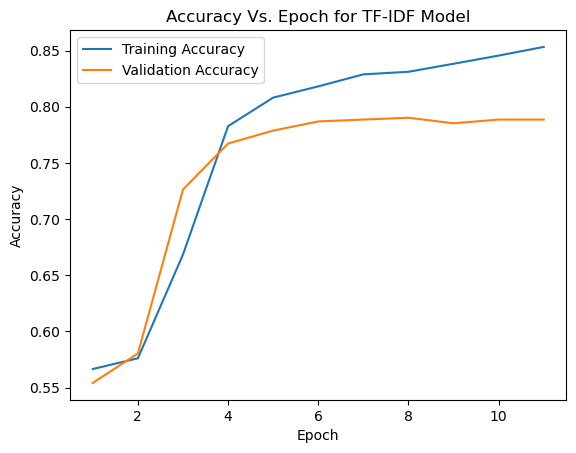

In [51]:
# Make visualization of accuracy and val accuracy vs. epoch for best model
epochs = [i + 1 for i in range(11)]

line1, = plt.plot(epochs, best_history.history["accuracy"], zorder = 0, label = "Training Accuracy")
line2, = plt.plot(epochs, best_history.history["val_accuracy"], zorder = 1, label = "Validation Accuracy")

plt.legend(handles = [line1, line2])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs. Epoch for TF-IDF Model")
plt.show()

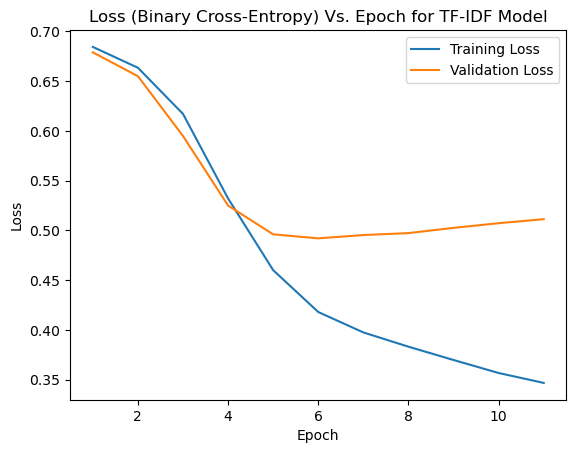

In [52]:
# Make visualization of loss, val_loss vs. epoch for best model
line1, = plt.plot(epochs, best_history.history["loss"], zorder = 0, label = "Training Loss")
line2, = plt.plot(epochs, best_history.history["val_loss"], zorder = 1, label = "Validation Loss")

plt.legend(handles = [line1, line2])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (Binary Cross-Entropy) Vs. Epoch for TF-IDF Model")
plt.show()

### Model Commentary:

The best model started with $\eta = 5 \times 10^{-5}$. I used learning rate scheduling to help prevent overfitting. The graphs show that the optimal number of epochs to train the model was either 10 or 11, because the validation loss did not decrease nor the accuracy meaningfully increase after that. Let's go ahead and make predictions on the test set, submit to kaggle, then compare against the RNN model. For my RNN I will use the Long Short Term Memory model from the Keras API.

In [53]:
#Make test set predictions

yhat = best_history.model.predict(X_test)
yhat = yhat.reshape(yhat.shape[0], )
yhat = yhat.tolist()
predictions = [round(yhat[i]) for i in range(len(yhat))]
tweets_test_df["target"] = predictions

102/102 [==============================] - 0s 2ms/step


In [54]:
ANNPrediction = tweets_test_df.set_index('id')
ANNPrediction.drop('text', axis=1, inplace=True)

In [55]:
ANNPrediction.to_csv("./ANNPrediction.csv")

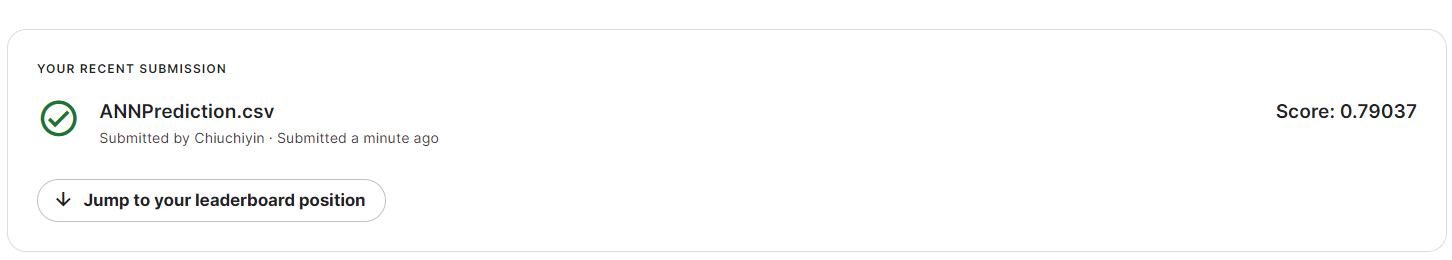79% accuracy isn't great. Hopefully using an RNN we can do better. Let's try!

In [57]:
# Citation https://medium.com/when-i-work-data/converting-a-pandas-dataframe-into-a-tensorflow-dataset-752f3783c168
#Make training, validation, and test TensorSlices Data objects from pandas dataframes.
from random import sample
import math
val_size = 0.08
num_train = math.floor((1 - val_size) * tweets_train_df.shape[0])
train_rows = sample([i for i in range(tweets_train_df.shape[0])], num_train)
val_rows = [i for i in range(tweets_train_df.shape[0]) if not i in train_rows]

training_df = tweets_train_df.iloc[train_rows]
validation_df = tweets_train_df.iloc[val_rows]

features = "text"
training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(training_df[features].values, tf.string),
            tf.cast(training_df['target'].values, tf.int32)
        )
    )
)

validation_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(validation_df[features].values, tf.string),
            tf.cast(validation_df['target'].values, tf.int32)
        )
    )
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(tweets_test_df["text"].values, tf.string)
        )
    )
)

In [58]:
BUFFER_SIZE = 10000
BATCH_SIZE = 10

for example, label in training_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())
    
training_dataset = training_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

text:  b'purple heart vet find jihad threat car mall islamaphobe vet http co hwnyxxkczz'
label:  0


In [59]:
#Make auto encoder that uses the same number of features as TF-IDF
#Citation https://www.tensorflow.org/text/tutorials/text_classification_rnn
num_words = 1000
encoder = tf.keras.layers.TextVectorization(
max_tokens = num_words)
encoder.adapt(training_dataset.map(lambda text, label: text)
)

def buildRNN_Model(eta):
    """
        
    """
    
    model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
    input_dim = len(encoder.get_vocabulary()),
    output_dim = 128,
    mask_zero = True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
    ])
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate = eta,
      decay_steps = 1000,
      decay_rate=0.9
    ) 
    
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )    
    return(model)

def gridSearchRNN(eta_to_try, training_dataset):
    """
        Hyperparameter optimizer for RNN with autoencoder
        Input: list of floats eta_to_try
        Output: (keras.callbacks.History best_history, float best_eta) current_best[1:]
    """
    callbacks_list =  [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5, mode = "min")]

    current_best = (0, None, None)
    for eta in eta_to_try:
        print("Now fitting model with eta =", eta)
        this_model = buildRNN_Model(eta)
        this_history = this_model.fit(training_dataset,
                            validation_data = validation_dataset,
                            epochs = 50,
                            callbacks = callbacks_list,
                            verbose = 0
                           )
        print("Got last validation accuracy of:", this_history.history["val_accuracy"][-1])
        if this_history.history["val_accuracy"][-1] > current_best[0]:
            current_best = (this_history.history["val_accuracy"][-1], this_history, eta)
        
    return(current_best[1:])

In [60]:
eta_to_try = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]
(best_history, best_eta) = gridSearchRNN(eta_to_try, training_dataset)

Now fitting model with eta = 1e-05
Got last validation accuracy of: 0.7704917788505554
Now fitting model with eta = 5e-05
Got last validation accuracy of: 0.8163934350013733
Now fitting model with eta = 0.0001
Got last validation accuracy of: 0.8196721076965332
Now fitting model with eta = 0.0005
Got last validation accuracy of: 0.7819672226905823
Now fitting model with eta = 0.001
Got last validation accuracy of: 0.7803278565406799


In [61]:
best_history.model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, None, 128)         128000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_54 (Dense)            (None, 64)                16448     
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                                                                 
 dense_55 (Dense)            (None, 16)              

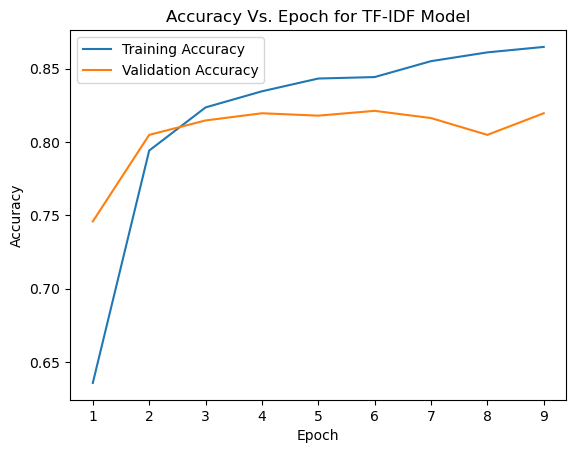

In [63]:
# Make visualization of accuracy and val accuracy vs. epoch for best model
epochs = [i + 1 for i in range(9)]

line1, = plt.plot(epochs, best_history.history["accuracy"], zorder = 0, label = "Training Accuracy")
line2, = plt.plot(epochs, best_history.history["val_accuracy"], zorder = 1, label = "Validation Accuracy")

plt.legend(handles = [line1, line2])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs. Epoch for TF-IDF Model")
plt.show()

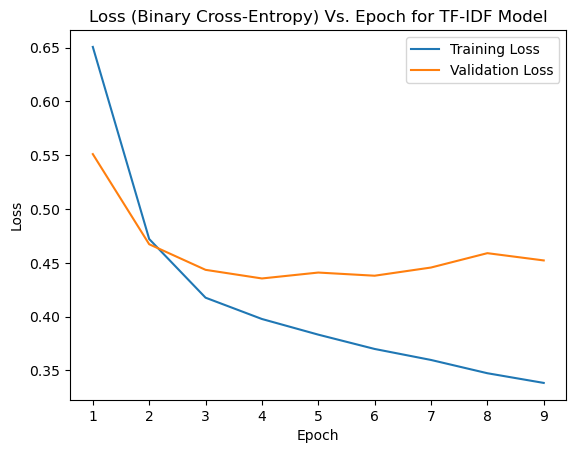

In [64]:
# Make visualization of loss, val_loss vs. epoch for best model
line1, = plt.plot(epochs, best_history.history["loss"], zorder = 0, label = "Training Loss")
line2, = plt.plot(epochs, best_history.history["val_loss"], zorder = 1, label = "Validation Loss")

plt.legend(handles = [line1, line2])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (Binary Cross-Entropy) Vs. Epoch for TF-IDF Model")
plt.show()

In [65]:
best_eta

0.0001

## Model Commentary:

The best RNN model had $\eta = 5 \times 10^{-5}$. The best validation accuracy was 0.789, which is only barely better than the ANN with TF-IDF. That indicates to us that without inclusion of the keyword and location information, there is some reason to believe that there is a pretty low boundary on learnability. Some people just tweet like the world's on fire. We need to submit our test results to Kaggle to make a fair comparison though. Let's do that.

In [67]:
#Make test set predictions

yhat = best_history.model.predict(test_dataset)
yhat = yhat.reshape(yhat.shape[0], )
yhat = yhat.tolist()
predictions = [round(yhat[i]) for i in range(len(yhat))]
tweets_test_df["target"] = predictions

327/327 [==============================] - 3s 8ms/step


In [68]:
RNNPrediction = tweets_test_df.set_index('id')
RNNPrediction.drop('text', axis=1, inplace=True)
RNNPrediction.to_csv("./RNNPrediction.csv")

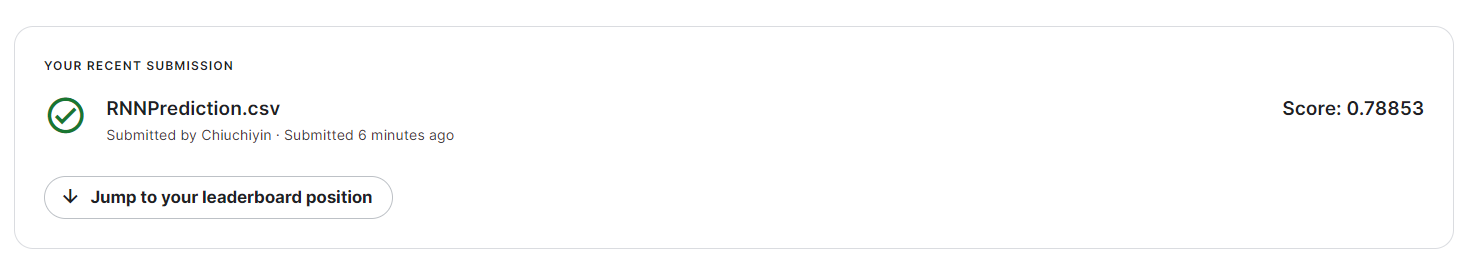

## Results and Conclusion

In this project I compared two different model architectures that attempted to classify tweets as either "disaster" or "not disaster". The first model I tried was an artificial nueral network that took as an input a TF-IDF matrix. I trained the TF-IDF features on only the training data - we could have artificially increased the test accuracy by including the test tweets in the input features (TF-IDF is unsupervised, so the lack of labels would not have been an impedement). This is borderline unethical - the function of test data is to determine how well the model would perform on data it has never seen before. We didn't do that. The ANN with TF-IDF yielded a test set accuracy of 0.79037. 

The second model I used was a RNN with a bi-directional LSTM layer. The LSTM layer used an auto-encoder as input, which was probably suboptimal. In the future I would like to find a way to make the LSTM layer take as input my TF-IDF matrix to (1) prevent duplication of effort, and (2) potentially increase test set accuracy. I couldn't manage to align the shapes in this project to make that work, but I just need more experience with Keras. That would be a good follow up project. As is, the RNN returned a test set accuracy of 0.78853, which is *slightly* worse than the ANN. 

I learned a lot in this project, and am eager to use my new NLP tools in Keras to perhaps do sentiment analysis. For a future data mining project I want to predict youtube views based on a variety of inputs. These NLP techniques will help include video title in those inputs. Thanks for taking the time to review my project!

Here's my final leaderboard position for the Kaggle competition:

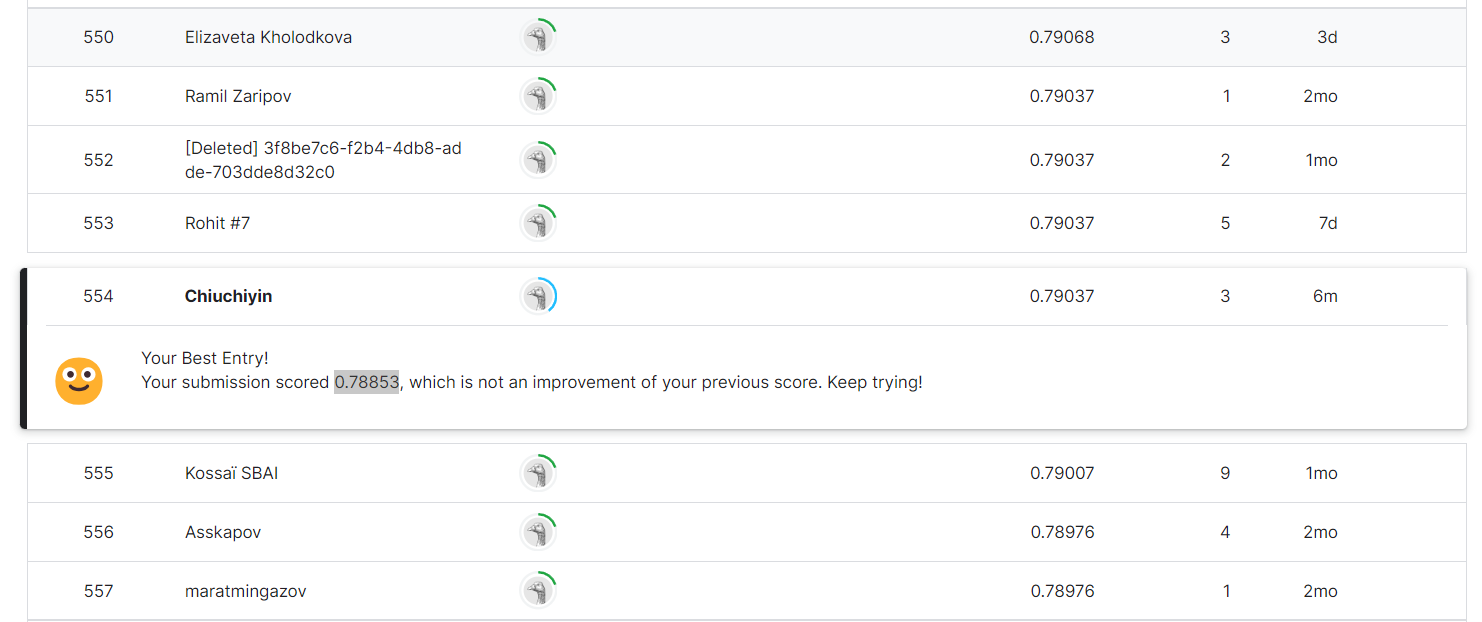